In [1]:
import pandas as pd
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import scikit_posthocs as sp
from sympy import S, symbols, printing

colors = sns.color_palette("pastel")
plt.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

generate_figs = True

In [2]:
if generate_figs:
    # Use LaTeX fonts in the plot
    # You may need to install a TeX font package: apt install cm-super
    # https://github.com/matplotlib/matplotlib/issues/16911
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

In [3]:
def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

# Load Data

In [4]:
# Sorted according to preference score
captcha_type = {
    "type_5c_captcha": "reCAPTCHA (easy click)",
    "type_4c_captcha": "reCAPTCHA (hard click)",
    "type_6_captcha": "Geetest (slide)",
    "type_3_captcha": "Arkose (selection)",
    "type_2_captcha": "Arkose (rotation)",
    "type_9_captcha": "Distorted text (simple)",
    "type_7_captcha": "Distorted text (moving)",
    "type_5i_captcha": "reCAPTCHA (easy image)",
    "type_4i_captcha": "reCAPTCHA (hard image)",
    "type_8_captcha": "Distorted text (masked)",
    "type_1_captcha": "hCAPTCHA (easy)",
    "type_0_captcha": "hCAPTCHA (difficult)",
}

label_to_show = {
    "reCAPTCHA (easy click)": "reCAPTCHA\n(easy click)",
    "reCAPTCHA (hard click)": "reCAPTCHA\n(hard click)",
    "Geetest (slide)": "Geetest\n(slide)",
    "Arkose (selection)": "Arkose\n(selection)",
    "Arkose (rotation)": "Arkose\n(rotation)",
    "Distorted text (simple)": "Distorted\ntext (simple)",
    "Distorted text (moving)": "Distorted\ntext (moving)",
    "reCAPTCHA (easy image)": "reCAPTCHA\n(easy image)",
    "reCAPTCHA (hard image)": "reCAPTCHA\n(hard image)",
    "Distorted text (masked)": "Distorted\ntext (masked)",
    "hCAPTCHA (easy)": "hCAPTCHA\n(easy)",
    "hCAPTCHA (difficult)": "hCAPTCHA\n(difficult)",
}

In [5]:
# Read json 
with open('../data/data.json', 'r') as d:
    json_object = json.load(d)
with open('../data/data_biased.json', 'r') as bd:
    json_object_b = json.load(bd)
with open('../data/data_unbiased.json', 'r') as ubd:
    json_object_ub = json.load(ubd)

# Import json as pandas data frame
df_total    = pd.DataFrame.from_dict(json_object)
df_b        = pd.DataFrame.from_dict(json_object_b)
df_ub       = pd.DataFrame.from_dict(json_object_ub)

df_total["reCAPTCHA (hard click)"] = df_total["reCAPTCHA (difficult)"].sort_values()[:713]
df_total["reCAPTCHA (hard image)"] = df_total["reCAPTCHA (difficult)"].sort_values()[712:]
df_total["reCAPTCHA (easy click)"] = df_total["reCAPTCHA (easy)"].sort_values()[:851]
df_total["reCAPTCHA (easy image)"] = df_total["reCAPTCHA (easy)"].sort_values()[850:]

df_b["reCAPTCHA (hard click)"] = df_b["reCAPTCHA (difficult)"].sort_values()[:351]
df_b["reCAPTCHA (hard image)"] = df_b["reCAPTCHA (difficult)"].sort_values()[350:]
df_b["reCAPTCHA (easy click)"] = df_b["reCAPTCHA (easy)"].sort_values()[:414]
df_b["reCAPTCHA (easy image)"] = df_b["reCAPTCHA (easy)"].sort_values()[413:]

df_ub["reCAPTCHA (hard click)"] = df_ub["reCAPTCHA (difficult)"].sort_values()[:373]
df_ub["reCAPTCHA (hard image)"] = df_ub["reCAPTCHA (difficult)"].sort_values()[372:]
df_ub["reCAPTCHA (easy click)"] = df_ub["reCAPTCHA (easy)"].sort_values()[:456]
df_ub["reCAPTCHA (easy image)"] = df_ub["reCAPTCHA (easy)"].sort_values()[455:]


# Plotting

## Plot timing data for each captcha type

In [6]:
def plot_timing_data(df):
    dd = pd.melt(df, id_vars=[], value_vars=captcha_type.values(),
                 var_name='Captcha Type', value_name='Solving Time')
    plt.figure(figsize=(5,6))
    sns.set_theme(style='ticks', palette='pastel')
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    sns.boxplot(x='Solving Time', y='Captcha Type', data=dd, showfliers=False, orient="h", whis=[0,95])
    locs, labels = plt.yticks()
    plt.yticks(locs, labels=[label_to_show[label.get_text()] for label in labels], rotation="horizontal")
    plt.xlim(0, 100)
    plt.ylabel("")
    plt.xlabel("Solving Time [s]")
    if generate_figs:
        fig_name = '../figs/captcha_timing_analysis.pdf'
        plt.savefig(fig_name, bbox_inches='tight')
    else:
        plt.show()

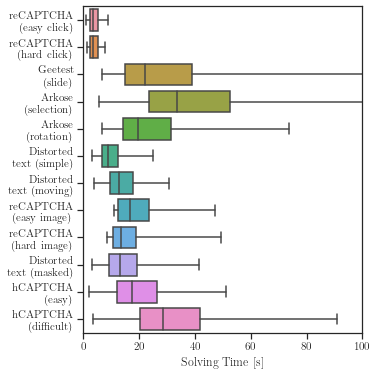

In [7]:
plot_timing_data(df_total)

## Plot demographic data

In [8]:
def plot_demographic_data(df, filter_keys, setting=''):
    
    data = {}

    for filter_key in filter_keys:
        result = []
        filter_values = df[filter_key].unique()
        for filter_value in filter_values:
            result.append(df[filter_key].value_counts()[filter_value])
    
        if filter_key == 'Age':
            plt.figure(figsize=(7,7))
            for r, v in zip(result, filter_values):
                plt.bar(int(v), r, color=colors[0])
                plt.text(int(v), r + 1, str(r), fontsize=8, horizontalalignment='center')
            plt.ylabel("Number of participants")
            plt.show()
        else:
            d = {}
            for k, v in zip(filter_values, result):
                if filter_key == 'Education':
                    if k == 'No Formal Education':
                        k = 'No Degree'
                    elif k == 'High School':
                        k = 'High\nSchool'

                # Remove any label that has _
                if k.find("_") > 0:
                    k = k[k.find("_") + 1:]

                d[k] = v
    
            # Sort dict so the largest comes to the left
            d = {k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse=True)}
    
            # Only show the top 5 countries
            if filter_key == 'Country of Residence':
                tmp_dict = {}
                for (k, v) in list(d.items())[:5]:
                    tmp_dict[k] = v
                tmp_dict['Other'] = sum(list(d.values())[5:])
                d = tmp_dict

            data[filter_key] = d
    
    # Draw stacked bar figure for the rest of the data
    plt.figure(figsize=(5,5))
    for key in data.keys():
        bottom = 0
        # Remove any label that has _
        if key == 'Country of Residence':
            x_label = 'Country\nof Residence'
        elif key == 'Device Type':
            x_label = 'Device\nType'
        elif key == 'Input Method':
            x_label = 'Input\nMethod'
        elif key == 'Internet Use':
            x_label = 'Internet\nUse'
        else:
            x_label = key.title()
        for i, (k, v) in enumerate(data[key].items()):
            plt.bar(x_label, v, bottom=bottom, color=colors[i])
            text_str = k + ' (' + str(v) + ')'
            if k == 'No Degree':
                plt.text(x_label, v/2 + bottom + 10, text_str, fontsize=6, horizontalalignment='center')
            elif k == 'Keyboard':
                plt.text(x_label, v/2 + bottom - 10, text_str, fontsize=6, horizontalalignment='center', verticalalignment='center')
            elif k == 'Computer':
                plt.text(x_label, v/2 + bottom + 10, text_str, fontsize=6, horizontalalignment='center', verticalalignment='center')
            else:
                plt.text(x_label, v/2 + bottom, text_str, fontsize=6, horizontalalignment='center', verticalalignment='center')
            bottom += v
    plt.ylabel("Number of participants")
    if generate_figs and setting == 'unbiased':
        fig_name = '../figs/biased_demographics.pdf'
        plt.savefig(fig_name, bbox_inches='tight')
    elif generate_figs and setting == 'biased':
        fig_name = '../figs/unbiased_demographics.pdf'
        plt.savefig(fig_name, bbox_inches='tight')
    elif generate_figs:
        fig_name = '../figs/demographics.pdf'
        plt.savefig(fig_name, bbox_inches='tight')
    else:
        plt.show()

### Unbiased demographics

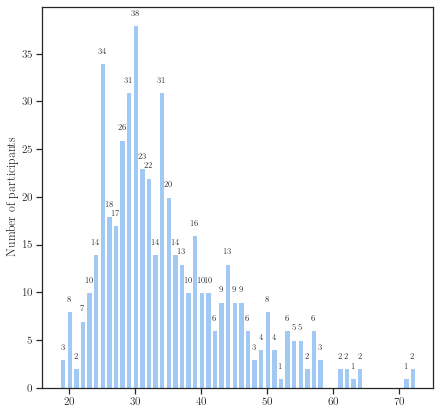

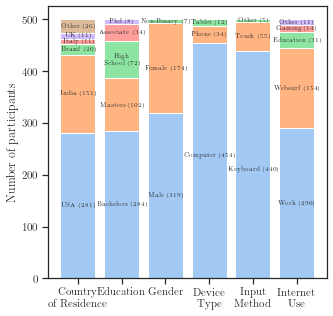

In [9]:
filter_keys = ["Age", "Country of Residence", "Education", "Gender", "Device Type", "Input Method", "Internet Use"]
plot_demographic_data(df_ub, filter_keys, 'unbiased')

### Biased demographics

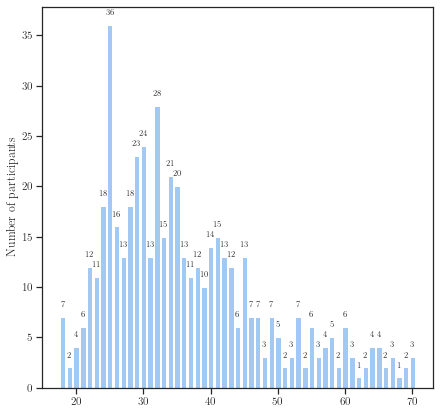

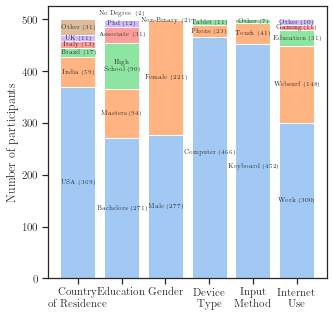

In [10]:
plot_demographic_data(df_b, filter_keys, 'biased')

### Combined demographics

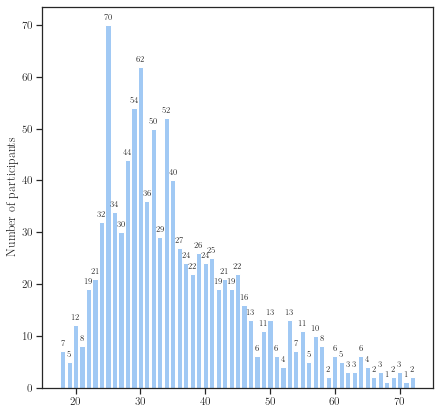

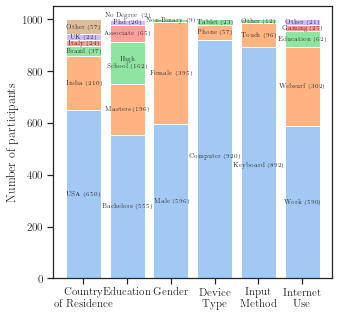

In [11]:
plot_demographic_data(df_total, filter_keys)

## Plot Preference results

In [12]:
def plot_captcha_pref_data(df):
    filter_keys = ["captcha_0_1_pref", "captcha_4_pref", "captcha_8_pref", "captcha_7_pref", "captcha_9_pref", "captcha_3_pref", "captcha_2_pref", "captcha_6_pref", "captcha_5_pref"]
    captcha_type = {
        "image"   : "$^\circ$",
        "text"    : "$^\dagger$",
        "game"    : "$^\diamond$",
        "slider"  : "$^\star$",
        "behavior": "$^\ddagger$"
    }
    captcha = {
        "captcha_0_1_pref": captcha_type["image"]    + "hCAPTCHA",
        "captcha_2_pref"  : captcha_type["game"]     + "Arkose\n(rotation)",
        "captcha_3_pref"  : captcha_type["game"]     + "Arkose\n(selection)",
        "captcha_4_pref"  : captcha_type["image"] + captcha_type["behavior"] + "reCAPTCHA\n(image)",
        "captcha_5_pref"  : captcha_type["image"] + captcha_type["behavior"] + "reCAPTCHA\n(click)",
        "captcha_6_pref"  : captcha_type["slider"]   + "Geetest\n(slide)",
        "captcha_7_pref"  : captcha_type["text"]     + "Distorted\ntext (moving)",
        "captcha_8_pref"  : captcha_type["text"]     + "Distorted\ntext (masked)",
        "captcha_9_pref"  : captcha_type["text"]     + "Distorted\ntext (simple)"
    }
    label_dict = {
        '1': "Least\nEnjoyable",
        '2': "Less\nEnjoyable",
        '3': "Neutral",
        '4': "More\nEnjoyable",
        '5': "Most\nEnjoyable"
    }

    # Remove responses that do not follow the directions (1 ~ 5)
    for idx, row in df.iterrows():
        tmp = row[filter_keys].to_list()
        if np.min(tmp) < 0 or 5 < np.max(tmp) or np.std(tmp) == 0:
            df = df.drop(index=idx)
    
    results = {}
    labels = []
    for filter_key in filter_keys:
        results[filter_key] = []
        filter_values = [1, 2, 3, 4, 5]
        for filter_value in filter_values:
            results[filter_key].append(df[filter_key].value_counts()[filter_value])
            labels.append(str(filter_value))

    # Calculate "Preference score" based on results
    preference_score = {}
    format_str = '{:2.5f}'
    for key, res in results.items():
        preference_score[key] = 0
        for i, r in enumerate(res):
            preference_score[key] += (i + 1) * float(format_str.format(r / sum(res)))

    # Sort keys based on preference score
    preference_score = dict(sorted(preference_score.items(), key=lambda item: item[1]))
    sorted_keys = preference_score.keys()
    
    # Plot preference
    plt.figure(figsize=(5,5))
    format_str_for_print = '{:2.1f}'
    for sorted_key in sorted_keys:
        left = 0
        for i, res in enumerate(results[sorted_key]):
            key = captcha[sorted_key]
            if sorted_key == "captcha_0_1_pref":
                plt.barh(key, res/sum(results[sorted_key])*100, left=left, color=colors[i], label=label_dict[labels[i]])
                plt.text(res/sum(results[sorted_key])*100/2 + left, key, (format_str_for_print + "%").format(res/sum(results[sorted_key])*100), horizontalalignment='center', verticalalignment='center', fontsize=8)
            else:
                plt.barh(key, res/sum(results[sorted_key])*100, left=left, color=colors[i])
                plt.text(res/sum(results[sorted_key])*100/2 + left, key, (format_str_for_print + "%").format(res/sum(results[sorted_key])*100), horizontalalignment='center', verticalalignment='center', fontsize=8)
            left += res/sum(results[sorted_key])*100
    
    # Display captcha type
    textstr = '\n'.join((
        '$\circ$ Image-based',
        '$\dagger$ Distorted-text',
        '$\diamond$ Game-based',
        '$\star$ Slider-based',
        '$\ddagger$ Behavior-based'
    ))
    props = dict(boxstyle='round', facecolor='white', edgecolor='lightgrey')
    plt.text(-25, -1.1, textstr, fontsize=8, verticalalignment='center', horizontalalignment='left', bbox=props)
    
    plt.yticks(range(len(sorted_keys)), labels=[captcha[key] for key in sorted_keys], rotation=0)
    plt.xlim(0,100)
    plt.xlabel("Percentage of Participants")
    plt.legend(loc='upper center', bbox_to_anchor=(0.4, -0.12), ncol=5, fontsize=8)
    if generate_figs:
        fig_name = '../figs/preference_result_stacked_bar.pdf'
        plt.savefig(fig_name, bbox_inches='tight')
    else:
        plt.show()
    return preference_score

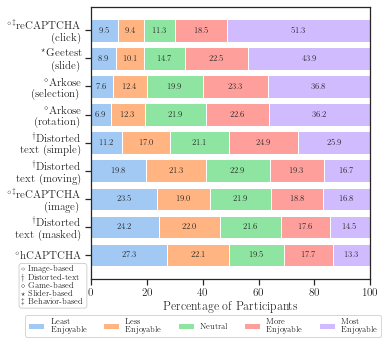

In [13]:
preference_score = plot_captcha_pref_data(df_total)

## Comparing Biased and Unbiased timing

In [14]:
# Remove outliers out of 5~95 percentile
def remove_outliers(x):
    a = np.array(x)
    a = a[np.where(a > 0)]

    result = a[np.where((a >= np.percentile(a, 0)) & (a <= np.percentile(a, 95)))]
    
    return result.tolist()

In [15]:
def print_mean():
    filter_keys = ["reCAPTCHA (easy click)", "reCAPTCHA (hard click)", "Geetest (slide)", "Arkose (selection)", "Arkose (rotation)", "Distorted text (simple)",
                   "Distorted text (moving)", "reCAPTCHA (easy image)", "reCAPTCHA (hard image)", "Distorted text (masked)", "hCAPTCHA (difficult)", "hCAPTCHA (easy)"]

    for key in captcha_type.values():
        ub_time_data = np.array(remove_outliers(df_ub[key].dropna().to_list()))
        b_time_data  = np.array(remove_outliers(df_b[key].dropna().to_list()))
        time_data    = np.array(remove_outliers(df_total[key].dropna().to_list()))
        print(key)
        print("Unbiased: " + str(np.mean(ub_time_data)))
        print("Biased: "   + str(np.mean(b_time_data)))
        print("Combined: " + str(np.mean(time_data)))
        print()

In [16]:
print_mean()

reCAPTCHA (easy click)
Unbiased: 4.870053117782927
Biased: 3.092272264631044
Combined: 3.8098180693069406

reCAPTCHA (hard click)
Unbiased: 4.377457627118645
Biased: 3.0502042042042055
Combined: 3.6384416543574614

Geetest (slide)
Unbiased: 30.425785263157874
Biased: 28.21674315789474
Combined: 29.303839999999994

Arkose (selection)
Unbiased: 42.77700843881857
Biased: 34.81915611814347
Combined: 38.55783544303798

Arkose (rotation)
Unbiased: 28.12986315789474
Biased: 18.053814736842106
Combined: 23.025086315789476

Distorted text (simple)
Unbiased: 10.447875789473688
Biased: 8.963557894736843
Combined: 9.656822105263158

Distorted text (moving)
Unbiased: 14.443972631578946
Biased: 12.497616842105264
Combined: 13.40481789473684

reCAPTCHA (easy image)
Unbiased: 26.271142857142877
Biased: 16.06107317073171
Combined: 18.97775352112677

reCAPTCHA (hard image)
Unbiased: 17.90731404958687
Biased: 14.48049295774648
Combined: 15.853457875457918

Distorted text (masked)
Unbiased: 15.31050736842

In [17]:

def plot_bias_vs_unbias(df):
    filter_keys = ["reCAPTCHA (easy click)", "reCAPTCHA (hard click)", "Geetest (slide)", "Arkose (selection)", "Arkose (rotation)", "Distorted text (simple)",
                   "Distorted text (moving)", "reCAPTCHA (easy image)", "reCAPTCHA (hard image)", "Distorted text (masked)", "hCAPTCHA (difficult)", "hCAPTCHA (easy)"]

    unbiased_time_data = {}
    biased_time_data   = {}
    for filter_key in filter_keys:
        unbiased_time_data[filter_key] = df_ub[filter_key].to_list()
        biased_time_data[filter_key]   = df_b[filter_key].to_list()

    rows = 2
    cols = len(unbiased_time_data) // rows

    axs = plt.figure(figsize=(cols*4,rows*4)).subplots(rows, cols)
    axs = trim_axs(axs, len(unbiased_time_data))

    for ax, key in zip(axs, captcha_type.values()):
        ub_time_data = remove_outliers(unbiased_time_data[key])
        b_time_data  = remove_outliers(biased_time_data[key])
        bins = range(0, int(max(ub_time_data)))
        ax.set_title(key.replace("_", " "), fontsize=18, fontweight='bold')
        ax.hist(ub_time_data, bins=bins, alpha=0.5, label='Unbiased (UB)', color='#1f77b4')
        ax.axvline(np.mean(ub_time_data), linestyle='dotted', color='#1f77b4', label='Mean (Unbiased)', lw=3)
        ax.hist(b_time_data, bins=bins, alpha=0.5, label='Biased (B)', color='#ff7f0e')
        ax.axvline(np.mean(b_time_data), linestyle='dotted', color='#ff7f0e', label='Mean (Biased)', lw=3)
#         ax.legend()
        props = dict(boxstyle='round',facecolor="white", edgecolor='lightgrey', alpha=0.5)
        ax.set_xlim(left=0)
        text_str = '\n'.join((
            "(UB)={:2.1f}".format(np.mean(ub_time_data)),
#             "Unbiased Std={:2.1f}".format(np.std(ub_time_data)),
            "(B)={:2.1f}".format(np.mean(b_time_data)),
#             "Biased Std={:2.1f}".format(np.std(b_time_data)),
            "(D)={:2.1f}\%".format((np.mean(ub_time_data) - np.mean(b_time_data)) / np.mean(b_time_data) * 100)
        ))
        ax.text(.99, 0.86, text_str, horizontalalignment='right', verticalalignment='center', transform=ax.transAxes, bbox=props, fontsize=15)
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [1, 0, 3, 2]
    plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc='lower center', bbox_to_anchor=(-2, -0.4), ncol=cols, fontsize=16)
#     if generate_figs:
    fig_name = '../figs/unbias_vs_bias_captcha_timing.pdf'
    plt.savefig(fig_name, bbox_inches='tight')
#     else:
    plt.show()

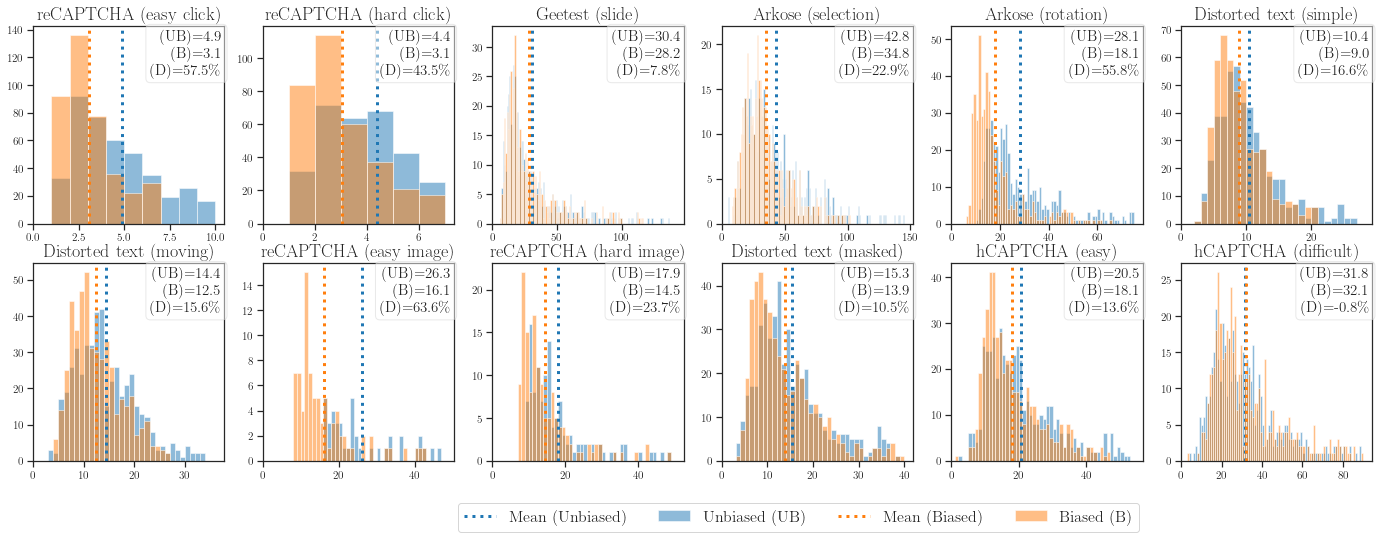

In [18]:
plot_bias_vs_unbias(df_total)

## Analysis on timing difference between captcha types

### Test normality

In [19]:
# Shapiro-Wilk test
def shapiro_wilk_test(df):
    threshold = 0.95
    for captcha in captcha_type.values():
        print(captcha)
        data = df[captcha][df[captcha] < df[captcha].quantile(threshold)]
        print(stats.shapiro(data))

In [20]:
shapiro_wilk_test(df_total)

reCAPTCHA (easy click)
ShapiroResult(statistic=0.9161500930786133, pvalue=9.847983434672299e-21)
reCAPTCHA (hard click)
ShapiroResult(statistic=0.9291418194770813, pvalue=2.3692151772496897e-17)
Geetest (slide)
ShapiroResult(statistic=0.7761219143867493, pvalue=4.2658469586150034e-34)
Arkose (selection)
ShapiroResult(statistic=0.8864160776138306, pvalue=8.581770036271341e-26)
Arkose (rotation)
ShapiroResult(statistic=0.8383592367172241, pvalue=5.6856743342493505e-30)
Distorted text (simple)
ShapiroResult(statistic=0.910290539264679, pvalue=3.180341964318995e-23)
Distorted text (moving)
ShapiroResult(statistic=0.9562065601348877, pvalue=3.0975253727260916e-16)
reCAPTCHA (easy image)
ShapiroResult(statistic=0.7970791459083557, pvalue=9.531017468311642e-13)
reCAPTCHA (hard image)
ShapiroResult(statistic=0.7705650329589844, pvalue=2.969584861413905e-19)
Distorted text (masked)
ShapiroResult(statistic=0.898034930229187, pvalue=1.2957455506306491e-24)
hCAPTCHA (easy)
ShapiroResult(statistic=

We can reject the null hypothesis in favor of the alternative, that the samples are drawn from a non-normal distribution.

### Test skewness of the probability distribution

In [21]:
# Null hypothesis: skewness of the population that the sample was drawn from is the same as that of a corresponding normal distribution.
def skewness_test(df):
    threshold = 0.95
    for captcha in captcha_type.values():
        print(captcha)
        data = df[captcha][df[captcha] < df[captcha].quantile(threshold)]
        print(stats.skewtest(data))

In [22]:
skewness_test(df_total)

reCAPTCHA (easy click)
SkewtestResult(statistic=8.720522976160048, pvalue=2.7691974510913017e-18)
reCAPTCHA (hard click)
SkewtestResult(statistic=6.55949646555695, pvalue=5.398977318307949e-11)
Geetest (slide)
SkewtestResult(statistic=16.841807831069136, pvalue=1.2049820504870603e-63)
Arkose (selection)
SkewtestResult(statistic=13.185372241609851, pvalue=1.0652687910088669e-39)
Arkose (rotation)
SkewtestResult(statistic=14.60315644440293, pvalue=2.6813778882307664e-48)
Distorted text (simple)
SkewtestResult(statistic=12.273031998378329, pvalue=1.264286707944583e-34)
Distorted text (moving)
SkewtestResult(statistic=8.336060179461953, pvalue=7.680683975702607e-17)
reCAPTCHA (easy image)
SkewtestResult(statistic=5.848986113359721, pvalue=4.945783725032838e-09)
reCAPTCHA (hard image)
SkewtestResult(statistic=9.327060398080938, pvalue=1.0884783817988345e-20)
Distorted text (masked)
SkewtestResult(statistic=12.392244512070944, pvalue=2.8787178727355787e-35)
hCAPTCHA (easy)
SkewtestResult(sta

We can see that solving time for all captchas are skewed.

### Test tailedness of the probability distribution

In [23]:
# Null hypothesis: The kurtosis of the population from which the sample was drawn is the same as that of the normal distribution
def kurtosis_test(df):
    threshold = 0.95
    for captcha in captcha_type.values():
        print(captcha)
        data = df[captcha][df[captcha] < df[captcha].quantile(threshold)]
        print(stats.kurtosistest(data))

In [24]:
kurtosis_test(df_total)

reCAPTCHA (easy click)
KurtosistestResult(statistic=-1.1375003841898157, pvalue=0.25532916407682127)
reCAPTCHA (hard click)
KurtosistestResult(statistic=-4.131290564226011, pvalue=3.607322625215183e-05)
Geetest (slide)
KurtosistestResult(statistic=9.776588480665653, pvalue=1.419134486142648e-22)
Arkose (selection)
KurtosistestResult(statistic=6.178267609663312, pvalue=6.480879503062434e-10)
Arkose (rotation)
KurtosistestResult(statistic=7.238126291241449, pvalue=4.549257352172922e-13)
Distorted text (simple)
KurtosistestResult(statistic=5.58486491201464, pvalue=2.3388193929753943e-08)
Distorted text (moving)
KurtosistestResult(statistic=0.699692956362103, pvalue=0.4841190762184978)
reCAPTCHA (easy image)
KurtosistestResult(statistic=2.6171957817986704, pvalue=0.00886554753508634)
reCAPTCHA (hard image)
KurtosistestResult(statistic=5.6171785876510185, pvalue=1.941007778141287e-08)
Distorted text (masked)
KurtosistestResult(statistic=5.107782592715183, pvalue=3.259613848241236e-07)
hCAPT

We can reject the null hypothesis in favor of the alternative for 9 out of 10 captchas and determine that they have a "heavily tailed" distribution.
Distorted text (moving) is the only distribution with a "lighter tail" compared to a normal distribution.

### Test equality of variance

In [25]:
def brown_forsythe_test(df):
    threshold = 0.95
    dd = [df[captcha][df[captcha] < df[captcha].quantile(threshold)] for captcha in captcha_type.values()]
    for i in range(len(captcha_type.values())):
        for j in range(i + 1, len(captcha_type.values())):
            type1 = str(list(captcha_type.values())[i])
            type2 = str(list(captcha_type.values())[j])
            _, p = stats.levene(dd[i], dd[j], center='mean')
            if p > 0.05:
                print("median")
                print(type1 + " vs " + type2 + ": " + str(p))
            _, p = stats.levene(dd[i], dd[j], center='trimmed')
            if p > 0.05:
                print("trimmed")
                print(type1 + " vs " + type2 + ": " + str(p))

In [26]:
brown_forsythe_test(df_total)

trimmed
reCAPTCHA (easy click) vs reCAPTCHA (hard click): 0.07659770050172837
median
Geetest (slide) vs Arkose (selection): 0.6126519580031171
median
reCAPTCHA (easy image) vs reCAPTCHA (hard image): 0.10227814874019944
median
reCAPTCHA (easy image) vs hCAPTCHA (easy): 0.1996518090769685
trimmed
reCAPTCHA (easy image) vs hCAPTCHA (easy): 0.15815951027557254
median
reCAPTCHA (hard image) vs Distorted text (masked): 0.822175140618568
trimmed
reCAPTCHA (hard image) vs Distorted text (masked): 0.14644880400415194


We can confirm that most of the captcha solving time distributions do not have equal variance.
Even for the conbination shown above, we still cannot use ANOVA tests, since the distribution is not normal.

### Test equality of mean

In [27]:
def kruskal_wallis_test(df):
    threshold = 0.95
    dd = [df[captcha][df[captcha] < df[captcha].quantile(threshold)] for captcha in captcha_type.values()]

    # The posthoc test compares each captcha to each other captcha
    dd = pd.DataFrame(dd).T
    dd = pd.melt(dd, id_vars=[], value_vars=captcha_type.values(),
                 var_name='Captcha Type', value_name='Solving Time')
    dd.dropna(inplace=True)

    ax = plt.figure(figsize=(14,10)).subplots()

    pc = None
    pc = sp.posthoc_conover(dd, val_col='Solving Time', group_col='Captcha Type', p_adjust='holm')
    # Format: diagonal, non-significant, p<0.001, p<0.01, p<0.05
    cmap = ['1', '#fb6a4a',  '#08306b',  '#4292c6', '#c6dbef']
    heatmap_args = {'cmap': cmap, 'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3], 'ax': ax, 'annot': pc}
    sp.sign_plot(pc, **heatmap_args)
    ax.set_title('Kruskal Wallis test amongst different CAPTCHA types')
    plt.show()

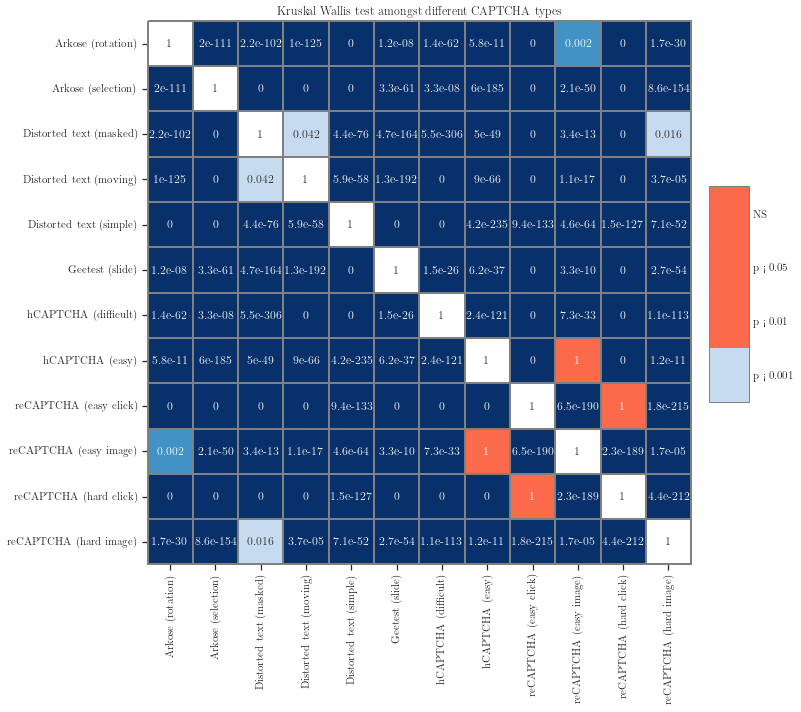

In [28]:
kruskal_wallis_test(df_total)

## Analysis on timing difference between captcha types and the effects of bias

It should fine to skip the preparation phase, since the data would taken from the distribution we have seen above (?)

In [29]:
def bias_kruskal_wallis_test(df):
    threshold = 0.95
    rows = 2
    cols = len(captcha_type) // rows

    axs = plt.figure(figsize=(cols*5,rows*5 + 0.5)).subplots(rows, cols)
    axs = trim_axs(axs, len(captcha_type))

    for i, (captcha, ax) in enumerate(zip(captcha_type.values(), axs)):
        dd = []
        # print(captcha)

        dd = [df[captcha][df['Bias'] == bias][df[captcha] < df[captcha].quantile(threshold)] for bias in ['Biased', 'Unbiased']]
        print_data = {bias: np.mean(data) for bias, data in zip(['Biased', 'Unbiased'], dd)}
        statistic, p_val = stats.kruskal(*dd, nan_policy='omit')
        print_data['statistic'] = statistic
        print_data['p value'] = p_val
        # print(print_data)

        # The posthoc test compares each demographic to each other demographic per captcha
        dd = pd.concat([data for data in dd])
        dd = pd.concat([dd, df['Bias']], axis=1)
        dd.dropna(inplace=True)

        pc = None
        pc = sp.posthoc_conover(dd, val_col=captcha, group_col='Bias', p_adjust='holm')
        # print(pc)
        # Format: diagonal, non-significant, p<0.001, p<0.01, p<0.05
        cmap = ['1', '#fb6a4a',  '#08306b',  '#4292c6', '#c6dbef']
        heatmap_args = {'cmap': cmap, 'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.93, 0.35, 0.04, 0.3], 'ax': ax, 'annot': pc}
        _, cbar_ax = sp.sign_plot(pc, **heatmap_args)
        if i != len(captcha_type) - 1:
            ax.figure.delaxes(cbar_ax.ax) # This is required to suppress annoying warnings
        ax.set_title(captcha)
    
    plt.show()

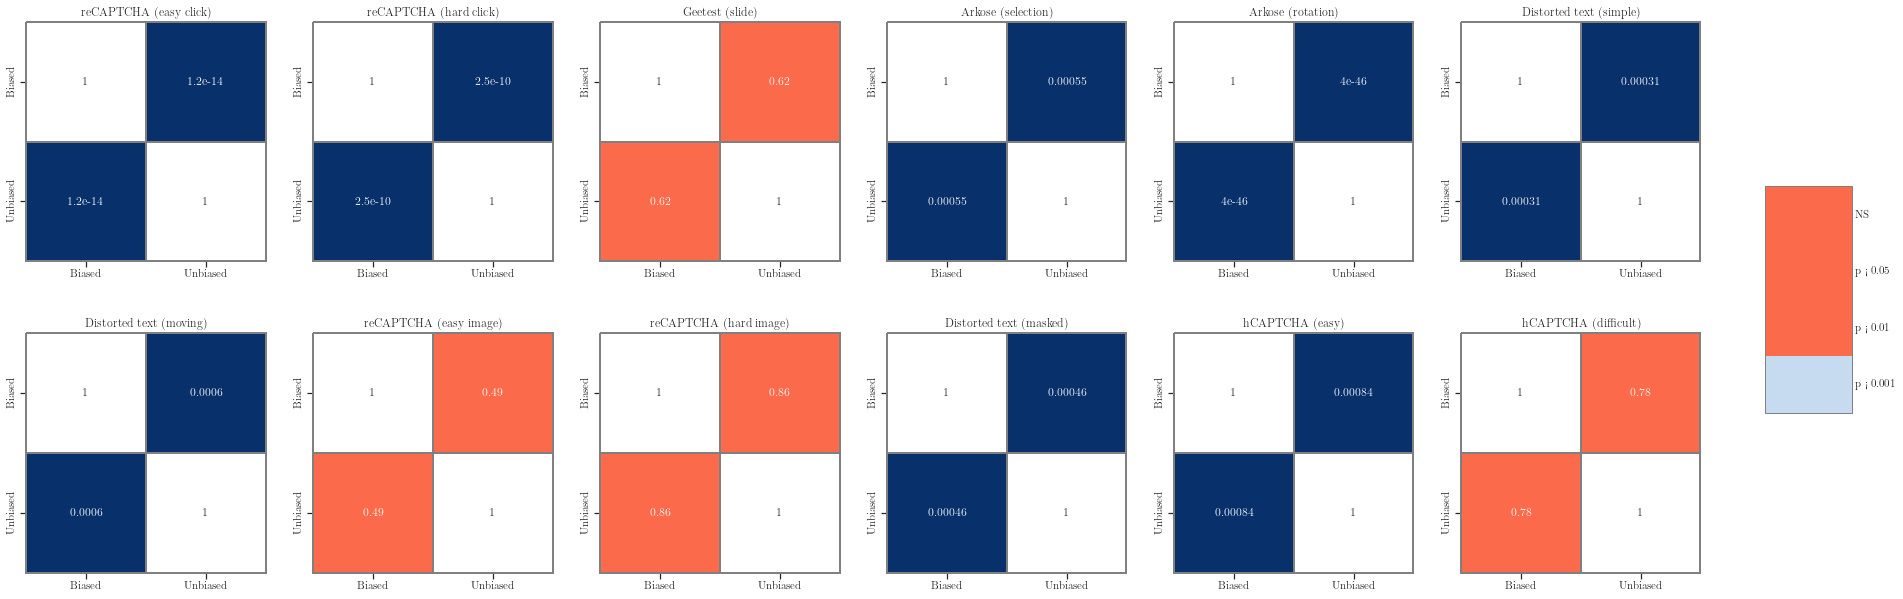

In [30]:
bias_kruskal_wallis_test(df_total)

In [31]:
def dem_kruskal_wallis_test(df, demographic, dem_keys=""):
    threshold = 0.95
    rows = 2
    cols = len(captcha_type) // rows

    axs = plt.figure(figsize=(cols*5,rows*5 + 0.5)).subplots(rows, cols)
    axs = trim_axs(axs, len(captcha_type))

    for i, (captcha, ax) in enumerate(zip(captcha_type.values(), axs)):
        dd = []
        # print(captcha)

        dd = [df[captcha][df[demographic] == dem][df[captcha] < df[captcha].quantile(threshold)] for dem in dem_keys]
        print_data = {dem: np.mean(data) for dem, data in zip(dem_keys, dd)}
        statistic, p_val = stats.kruskal(*dd, nan_policy='omit')
        print_data['statistic'] = statistic
        print_data['p value'] = p_val
        # print(print_data)

        # The posthoc test compares each demographic to each other demographic per captcha
        dd = pd.concat([data for data in dd])
        dd = pd.concat([dd, df[demographic]], axis=1)
        dd.dropna(inplace=True)

        pc = None
        pc = sp.posthoc_conover(dd, val_col=captcha, group_col=demographic, p_adjust='holm')
        # print(pc)
        # Format: diagonal, non-significant, p<0.001, p<0.01, p<0.05
        cmap = ['1', '#fb6a4a',  '#08306b',  '#4292c6', '#c6dbef']
        heatmap_args = {'cmap': cmap, 'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.93, 0.35, 0.04, 0.3], 'ax': ax, 'annot': pc}
        _, cbar_ax = sp.sign_plot(pc, **heatmap_args)
        if i != len(captcha_type) - 1:
            ax.figure.delaxes(cbar_ax.ax) # This is required to suppress annoying warnings
        ax.set_title(captcha)
    
    plt.show()

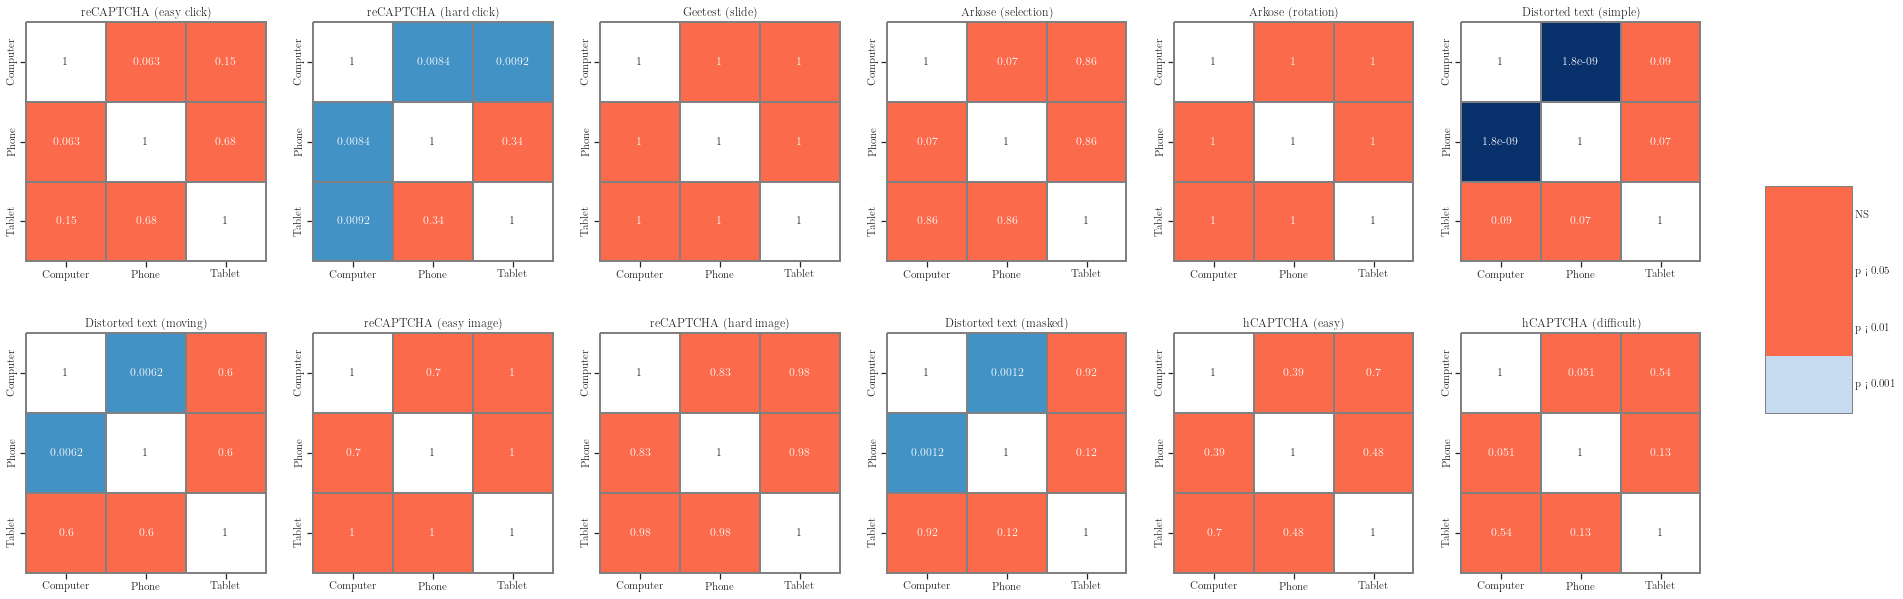

In [32]:
dem_kruskal_wallis_test(df_total, 'Device Type', ['Computer', 'Phone', 'Tablet'])

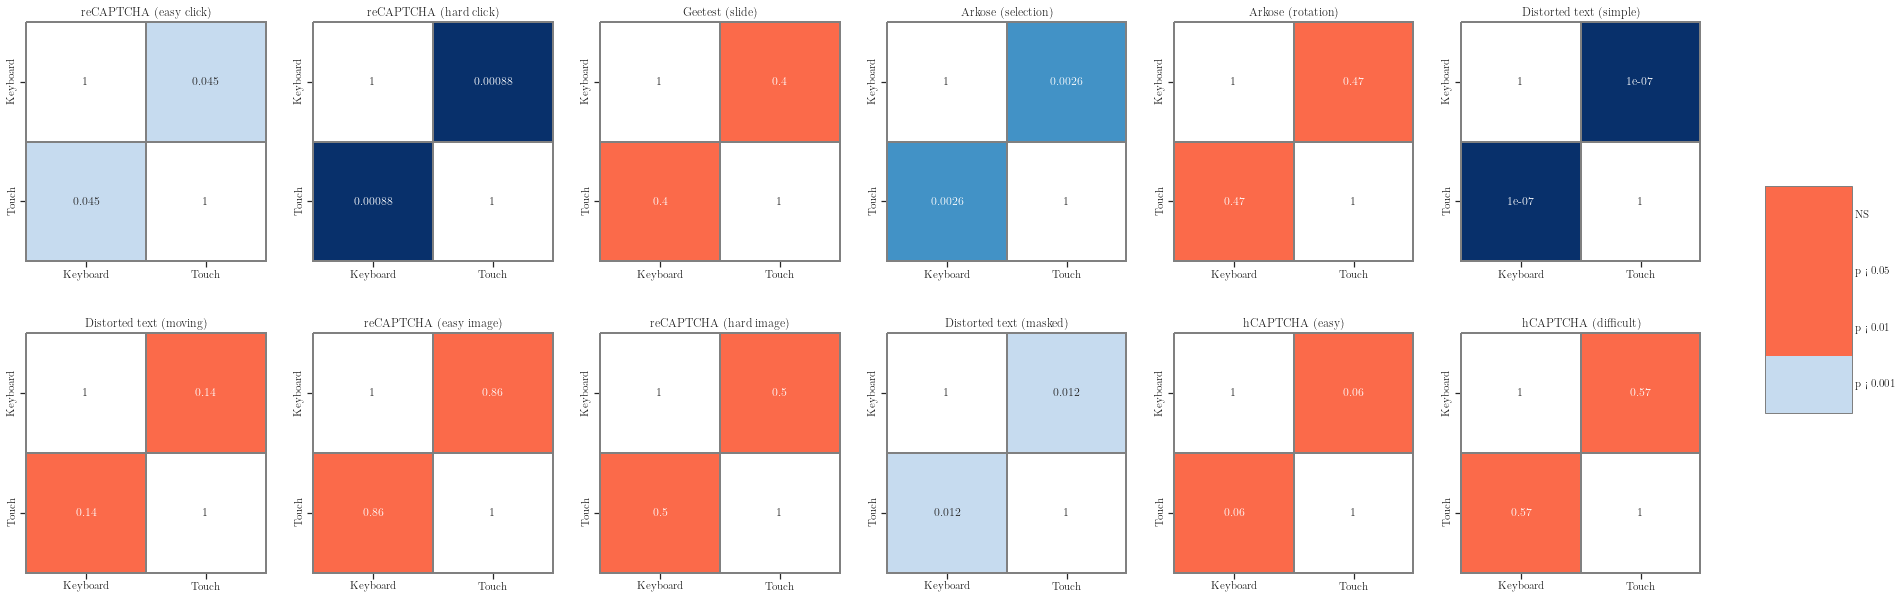

In [33]:
dem_kruskal_wallis_test(df_total, 'Input Method', ['Keyboard', 'Touch'])

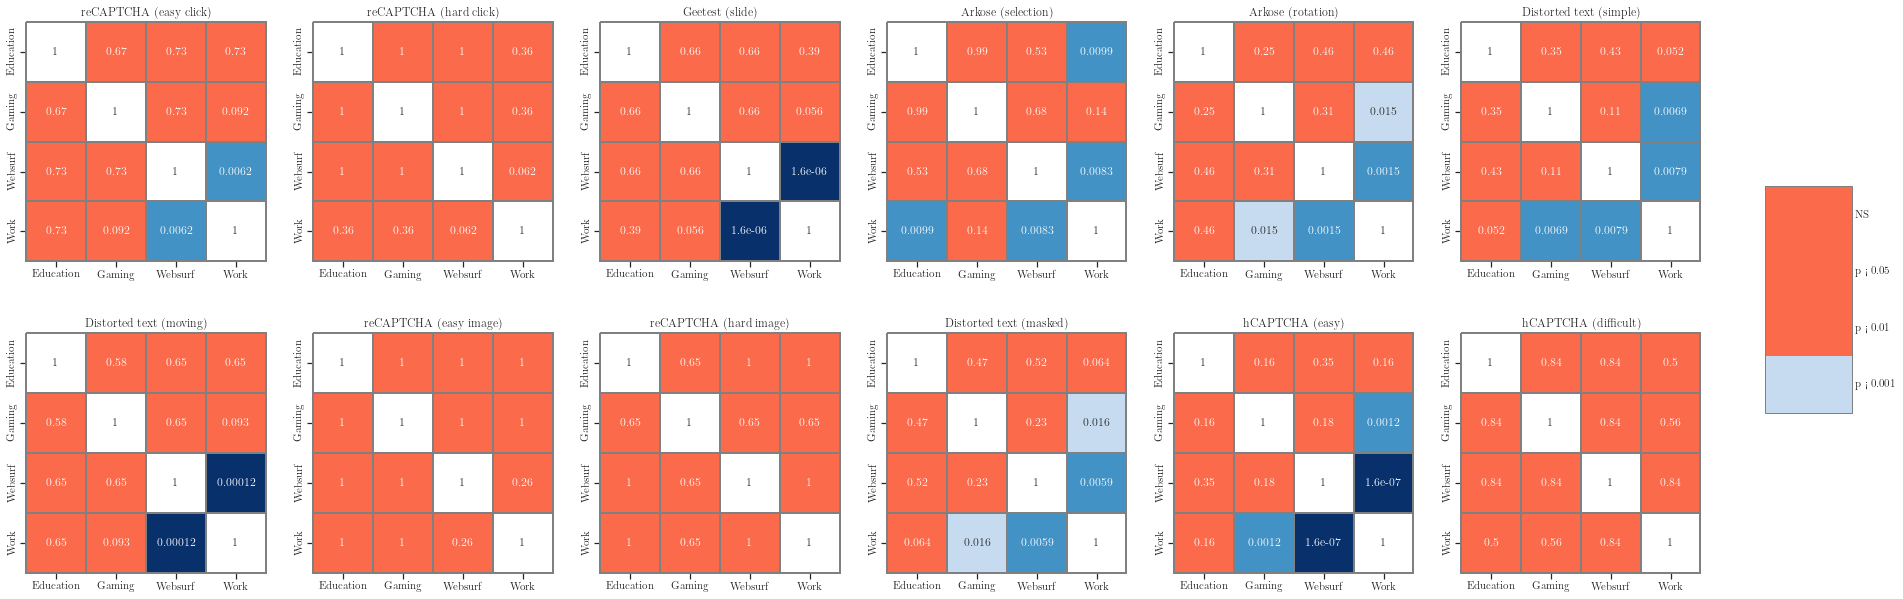

In [34]:
dem_kruskal_wallis_test(df_total, 'Internet Use', ['Work', 'Websurf', 'Education', 'Gaming'])

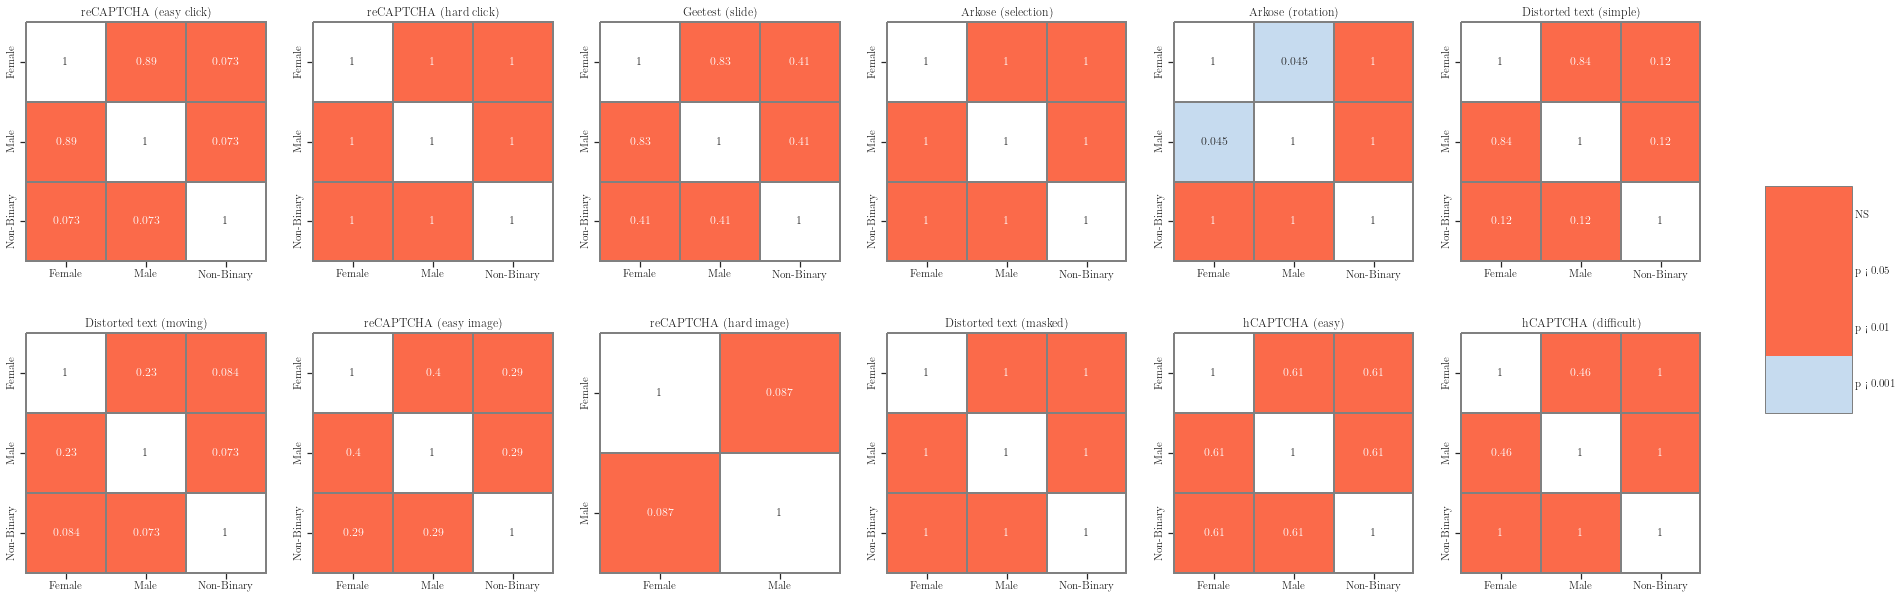

In [35]:
dem_kruskal_wallis_test(df_total, 'Gender', ['Male', 'Female', 'Non-Binary'])

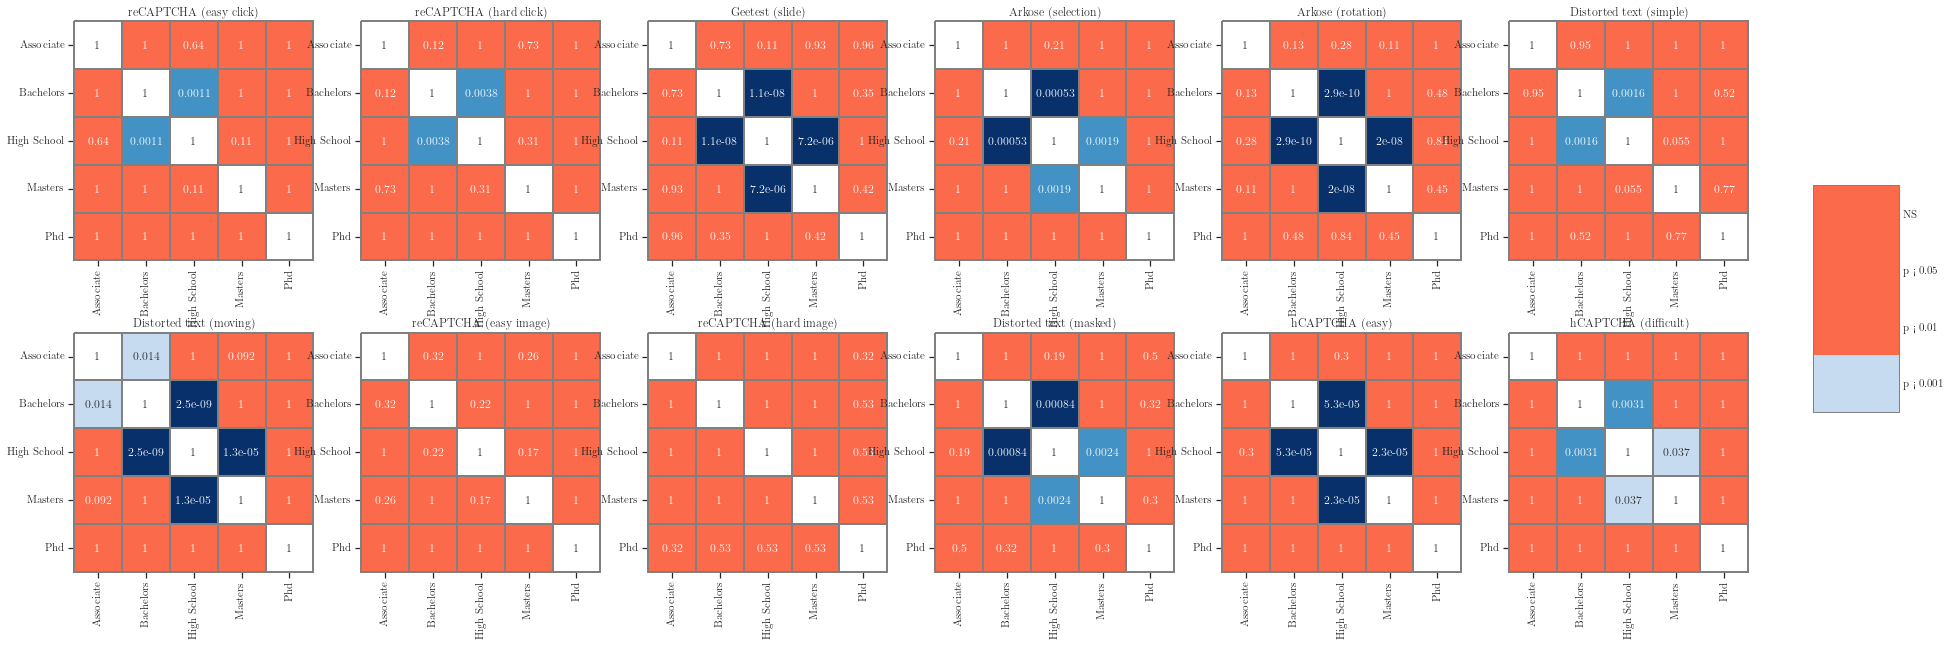

In [36]:
dem_kruskal_wallis_test(df_total, 'Education', ['High School', 'Associate', 'Bachelors', 'Masters', 'Phd'])

# Plot timing data for each captcha type with different demographics

### Age

In [37]:
# Remove outliers out of 5~95 percentile
def remove_outliers_age(x):
    a = np.array([val[0] for val in x])
    a = a[np.where(a > 0)]

    result = []
    for val in x:
        if val[0] >= np.percentile(a, 0) and val[0] <= np.percentile(a, 95):
            result.append(val)
    
    return result

# Solving time vs age
def plot_timing_data_vs_age(df):
    timing_data = {}
    timing_data_for_mean = {}
    filter_keys = ["reCAPTCHA (easy click)", "reCAPTCHA (hard click)", "Geetest (slide)", "Arkose (selection)", "Arkose (rotation)", "Distorted text (simple)",
                   "Distorted text (moving)", "reCAPTCHA (easy image)", "reCAPTCHA (hard image)", "Distorted text (masked)", "hCAPTCHA (difficult)", "hCAPTCHA (easy)"]
    for filter_key in filter_keys:
        timing_data[filter_key] = []
        timing_data_for_mean[filter_key] = {}

    for _, row in df.iterrows():
        for filter_key in filter_keys:
            timing_data[filter_key].append([row[filter_key], row["Age"]])

    # Sort and remove outliers
    for filter_key in filter_keys:
        val = timing_data[filter_key]
        val = sorted(val, key=lambda x: x[1])
        timing_data[filter_key] = remove_outliers_age(val)

    # Populate dict for calculating mean
    for filter_key in filter_keys:
        for v in timing_data[filter_key]:
            try:
                timing_data_for_mean[filter_key][v[1]].append(v[0])
            except:
                timing_data_for_mean[filter_key][v[1]] = []
                timing_data_for_mean[filter_key][v[1]].append(v[0])

    rows = 2
    cols = len(filter_keys) // rows
    axs = plt.figure(figsize=(4*cols,4*rows)).subplots(rows,cols)
    axs = trim_axs(axs, len(filter_keys))

    for ax, filter_key in zip(axs, filter_keys):
        val = timing_data[filter_key]
        ax.scatter([int(v[1]) for v in val], [v[0] for v in val], s=2, color='blue', alpha=0.5)

        # Plot mean line
        ax.plot([int(v[1]) for v in val], [np.mean(timing_data_for_mean[filter_key][v[1]]) for v in val], color="green", linewidth=2, alpha=1)

        # Calculate linear fit
        # See: https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html
        linear_model = np.polyfit([int(v[1]) for v in val], [v[0] for v in val], 1) # 1D or 2D?
        linear_model_fn = np.poly1d(linear_model)
        x = symbols("x")
        poly = sum(S("{:6.2f}".format(v))*x**i for i, v in enumerate(linear_model[::-1]))
        eq_latex = printing.latex(poly)

        # Plot linear fit
        unique_age_val = np.unique([int(v[1]) for v in val])
        x_s = np.arange(min(unique_age_val), max(unique_age_val))
        ax.plot(x_s, linear_model_fn(x_s), color="red", linewidth=2, alpha=1, label="${}$".format(eq_latex))

        ax.legend(loc='upper right')
        ax.set_title(filter_key, fontsize=18, fontweight='bold')
        ax.set_ylim(0,)

    if generate_figs:
        fig_name = "../figs/age_vs_time.pdf"
        plt.savefig(fig_name, bbox_inches='tight')
    else:
        plt.show()

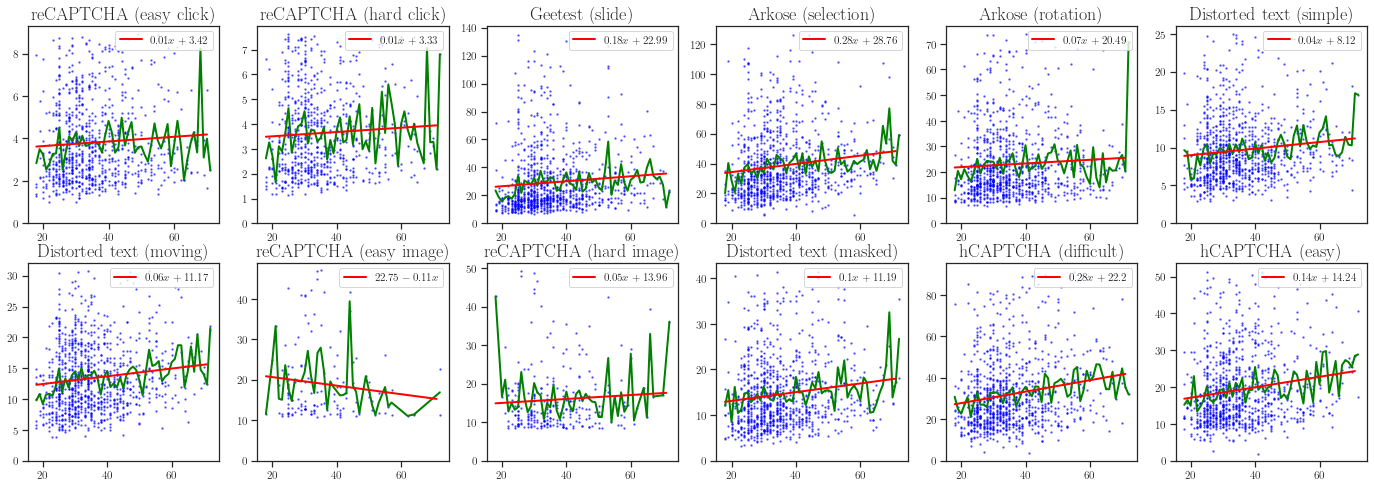

In [38]:
plot_timing_data_vs_age(df_total)

### Other demographics

In [39]:
def plot_timing_data_vs_dem_group_box(df, demographic, dem_keys=""):
    dd = pd.melt(df, id_vars=[demographic], value_vars=captcha_type.values(),
                 var_name='Captcha Type', value_name='Solving Time')
    if dem_keys == "":
        dem_keys = dd[demographic].unique()
    dd = dd[dd[demographic].isin(dem_keys)]
    plt.figure(figsize=(5,6))
    sns.set_theme(style='ticks', palette='pastel')
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    sns.boxplot(x='Solving Time', y='Captcha Type', hue=demographic, data=dd, showfliers=False, orient="h", whis=[0,95])
    plt.legend()
    locs, labels = plt.yticks()
    plt.yticks(locs, labels=[label_to_show[label.get_text()] for label in labels], rotation="horizontal")
    plt.xlim(0, 100)
    plt.ylabel("")
    plt.xlabel("Solving Time [s]")
    if generate_figs:
        fig_name = "../figs/" + demographic.lower().replace(" ", "_") + "_vs_time.pdf"
        plt.savefig(fig_name, bbox_inches='tight')
    else:
        plt.show()

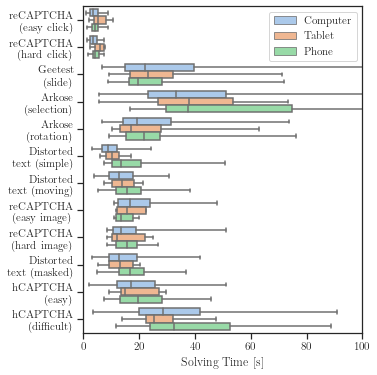

In [40]:
plot_timing_data_vs_dem_group_box(df_total, 'Device Type', ['Computer', 'Phone', 'Tablet'])

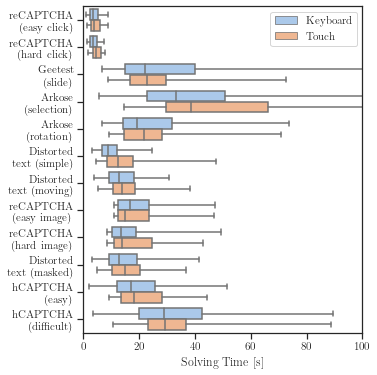

In [41]:
plot_timing_data_vs_dem_group_box(df_total, 'Input Method', ['Keyboard', 'Touch'])

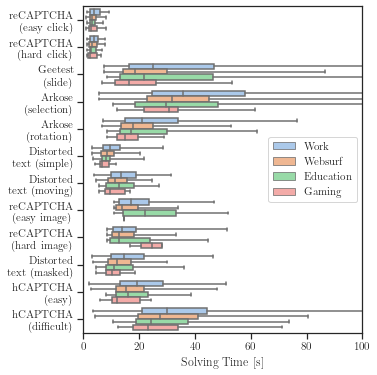

In [42]:
plot_timing_data_vs_dem_group_box(df_total, 'Internet Use', ['Work', 'Websurf', 'Education', 'Gaming'])

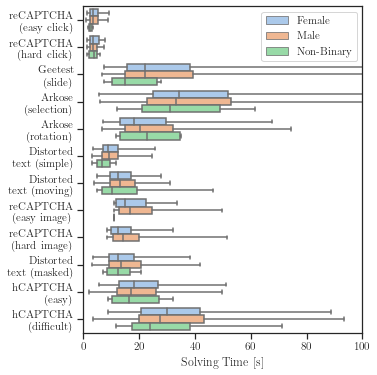

In [43]:
plot_timing_data_vs_dem_group_box(df_total, 'Gender', ['Male', 'Female', 'Non-Binary'])

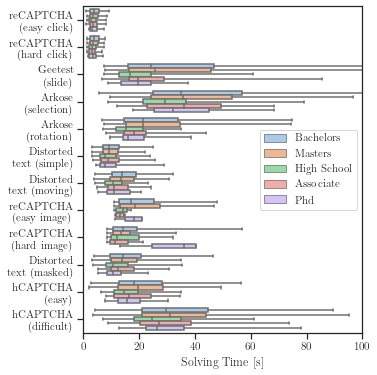

In [44]:
plot_timing_data_vs_dem_group_box(df_total, 'Education', ['High School', 'Associate', 'Bachelors', 'Masters', 'Phd'])

## Outliers

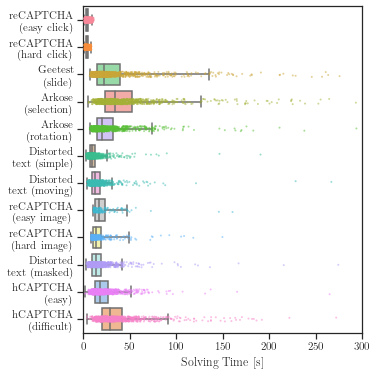

In [45]:
dd = pd.melt(df_total, value_vars=captcha_type.values(),
             var_name='Captcha Type', value_name='Solving Time')
dd = dd.dropna()
plt.figure(figsize=(5,6))
sns.set_theme(style='ticks')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
sns.boxplot(x='Solving Time', y='Captcha Type', data=dd, showfliers=False, orient="h", palette='pastel', whis=[0,95])
sns.stripplot(x='Solving Time', y='Captcha Type', data=dd, alpha=0.5, size=2)
locs, labels = plt.yticks()
plt.yticks(locs, labels=[label_to_show[label.get_text()] for label in labels], rotation="horizontal")
plt.xlim(0, 300)
# plt.xlim(0,)
plt.ylabel("")
plt.xlabel("Solving Time [s]")
if generate_figs:
    fig_name = '../figs/captcha_timing_analysis_appendix.pdf'
    plt.savefig(fig_name, bbox_inches='tight')
else:
    plt.show()

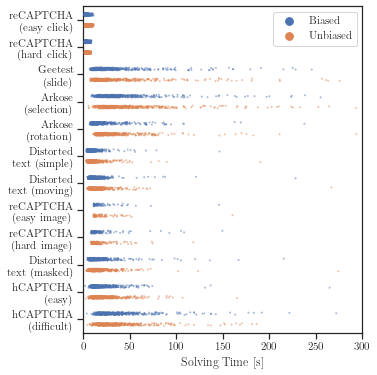

In [46]:
dd = pd.melt(df_total, id_vars=['Bias'], value_vars=captcha_type.values(),
             var_name='Captcha Type', value_name='Solving Time')
dd = dd.dropna()
plt.figure(figsize=(5,6))
sns.set_theme(style='ticks')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
sns.stripplot(x='Solving Time', y='Captcha Type', hue='Bias', data=dd, alpha=0.5, dodge=True, size=2)
locs, labels = plt.yticks()
plt.yticks(locs, labels=[label_to_show[label.get_text()] for label in labels], rotation="horizontal")
plt.xlim(0, 300)
plt.ylabel("")
plt.legend(title=None)
plt.xlabel("Solving Time [s]")
if generate_figs:
    fig_name = '../figs/captcha_timing_analysis_appendix_b_vs_ub.pdf'
    plt.savefig(fig_name, bbox_inches='tight')
else:
    plt.show()